In [1]:
import json
import matplotlib.pyplot as plt
import random
import spacy
import transformers

from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from bertopic.representation import (
    KeyBERTInspired,
    ZeroShotClassification,
    TextGeneration
)
from bertopic.vectorizers import ClassTfidfTransformer
from PIL import Image
from transformers import pipeline, AutoTokenizer
from torch import bfloat16
from ctransformers import AutoModelForCausalLM


In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
result_dir = "../results"
image_dir = "../data/Images"

nlp = spacy.load('en_core_web_sm')

def extract_verbs_nouns(sentence):
    doc = nlp(sentence)
    verbs_nouns = [token.text for token in doc if token.pos_ in {'VERB', 'NOUN'}]
    return " ".join(verbs_nouns)

def read_llava_captions(captions_path: str):
  with open(captions_path, 'r') as f:
    captions = json.load(f)

  for key, caption in captions.items():
    captions[key] = caption.replace('ER:  \nWhat is shown in this image? ASSISTANT: ', '')
    #captions[key] = caption.replace('ER:  \nGive me a short description of the image in one sentence? ASSISTANT: ', '')
  return captions

def read_blip_captions(captions_path: str):
  with open(captions_path, 'r') as f:
    captions = json.load(f)
    
  #for key, caption in captions.items():
  #  captions[key] = extract_verbs_nouns(caption)
  
  return captions

captions = read_llava_captions(f"{result_dir}/llava_captions.json")
#captions = read_blip_captions(f"{result_dir}/blip_captions.json")

## Llama 2 model

In [4]:
model_id = 'meta-llama/Llama-2-7b-chat-hf'

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Computation type
)

# Llama 2 Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# Llama 2 Model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
)
model.eval()

# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)

# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics.
<</SYS>>
"""

# Example prompt demonstrating the output we are looking for
example_prompt = """
I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.

[/INST] Environmental impacts of eating meat
"""

# Our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
[/INST]
"""

prompt = system_prompt + example_prompt + main_prompt

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `load_in_8bit_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

## Zephyr model

In [37]:

# Set gpu_layers to the number of layers to offload to GPU. Set to 0 if no GPU acceleration is available on your system.
model = AutoModelForCausalLM.from_pretrained(
    "TheBloke/zephyr-7B-alpha-GGUF",
    model_file="zephyr-7b-alpha.Q4_K_M.gguf",
    model_type="mistral",
    gpu_layers=50,
    hf=True
)
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceH4/zephyr-7b-alpha")

# Pipeline
generator = pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    max_new_tokens=50,
    repetition_penalty=1.1
)

prompt = """<|system|>You are a helpful, respectful and honest assistant for labeling topics..</s>
<|user|>
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.</s>
<|assistant|>"""

Fetching 1 files: 100%|██████████| 1/1 [13:08<00:00, 788.87s/it]
CUDA error 719 at /home/runner/work/ctransformers/ctransformers/models/ggml/ggml-cuda.cu:5087: unspecified launch failure


In [ ]:
# Step 1 - Extract embeddings
#embedding_model = SentenceTransformer("all-MiniLM-L12-v2").to('cuda')
#embedding_model = SentenceTransformer("paraphrase-MiniLM-L12-v2").to('cuda')
embedding_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2").to('cuda')

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=11, n_components=15, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=14, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english", max_df=0.8, min_df=0.1)

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step 6 - (Optional) Fine-tune topic representations with
# a `bertopic.representation` model
#candidate_topics = ['animals', 'flowers', 'sport', 'village/city', 'culture', 'food', 'nature and landscape', 'selfie']
#representation_model = ZeroShotClassification(candidate_topics, model='facebook/bart-large-mnli', min_prob=0.3)
#generator = pipeline('text2text-generation', model='google/flan-t5-base')
#representation_model = TextGeneration(generator)
# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)
# All representation models
representation_model = {
    "Llama2": llama2,
}
# Text generation with Zephyr
#zephyr = TextGeneration(generator, prompt=prompt)
#representation_model = {"Zephyr": zephyr}


# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic represenations
  top_n_words=15
)


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
list_captions = [cap for cap in captions.values()]
topics, probs = topic_model.fit_transform(list_captions)
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,70,-1_fence_backpacks_cloudy_walking,"[fence, backpacks, cloudy, walking, people, di...","[The image shows a group of people, likely hik..."
1,0,157,0_building_town_situated_white,"[building, town, situated, white, road, balcon...",[The image shows a small stone tower or a ston...
2,1,53,1_clear_blue_range_distance,"[clear, blue, range, distance, sky, set, valle...",[The image shows a beautiful view of a mountai...
3,2,46,2_ski_slope_lift_resort,"[ski, slope, lift, resort, skis, people, snowb...",[The image shows a man and a woman standing on...
4,3,41,3_water_waterfall_river_flowing,"[water, waterfall, river, flowing, bridge, lak...",[The image shows a river flowing through a val...
5,4,33,4_sunset_sun_stars_night,"[sunset, sun, stars, night, shining, city, war...",[The image shows a beautiful sunset over a mou...
6,5,31,5_tree_leaves_trees_forest,"[tree, leaves, trees, forest, tables, bare, bu...",[The image shows a large tree with a twisted t...
7,6,26,6_backpack_person_wearing_holding,"[backpack, person, wearing, holding, condition...","[The image shows a woman standing on a hill, h..."
8,7,26,7_table_hanging_display_food,"[table, hanging, display, food, various, color...",[The image shows a hanging display of various ...
9,8,21,8_close_flower_purple_focus,"[close, flower, purple, focus, perched, center...","[The image shows a close-up of a flower, with ..."


In [ ]:
topic_model.get_topics()

{-1: [('fence', 0.42389625090167465),
  ('backpacks', 0.41114250243720624),
  ('cloudy', 0.37264524415661343),
  ('walking', 0.35678065833202083),
  ('people', 0.3480370436697633),
  ('dish', 0.3462272750599646),
  ('woman', 0.3367849546284594),
  ('group', 0.3361249079256297),
  ('antenna', 0.3351819636511979),
  ('satellite', 0.3213444818634657),
  ('wearing', 0.3177934150037709),
  ('carrying', 0.315595396596456),
  ('shadow', 0.30967508907943936),
  ('outdoor', 0.30967508907943936),
  ('appear', 0.30932727588725994)],
 0: [('building', 0.3666345536324659),
  ('town', 0.3662967444173252),
  ('situated', 0.36244526917600955),
  ('white', 0.3359937910183693),
  ('road', 0.3352918690412606),
  ('balcony', 0.30720714144897404),
  ('street', 0.30205578731382215),
  ('located', 0.3020341256216361),
  ('stone', 0.3020341256216361),
  ('houses', 0.28884591782727376),
  ('area', 0.2888057485523869),
  ('house', 0.2844185463471295),
  ('mountainous', 0.28410087353704),
  ('doorway', 0.2646412

In [ ]:
str_topics = [topic_model.get_topic(x) for x in topics]

result = []
for topic in str_topics:
  temp = ""
  for word, value in topic:
    temp += word + " "
  result.append(temp.strip())

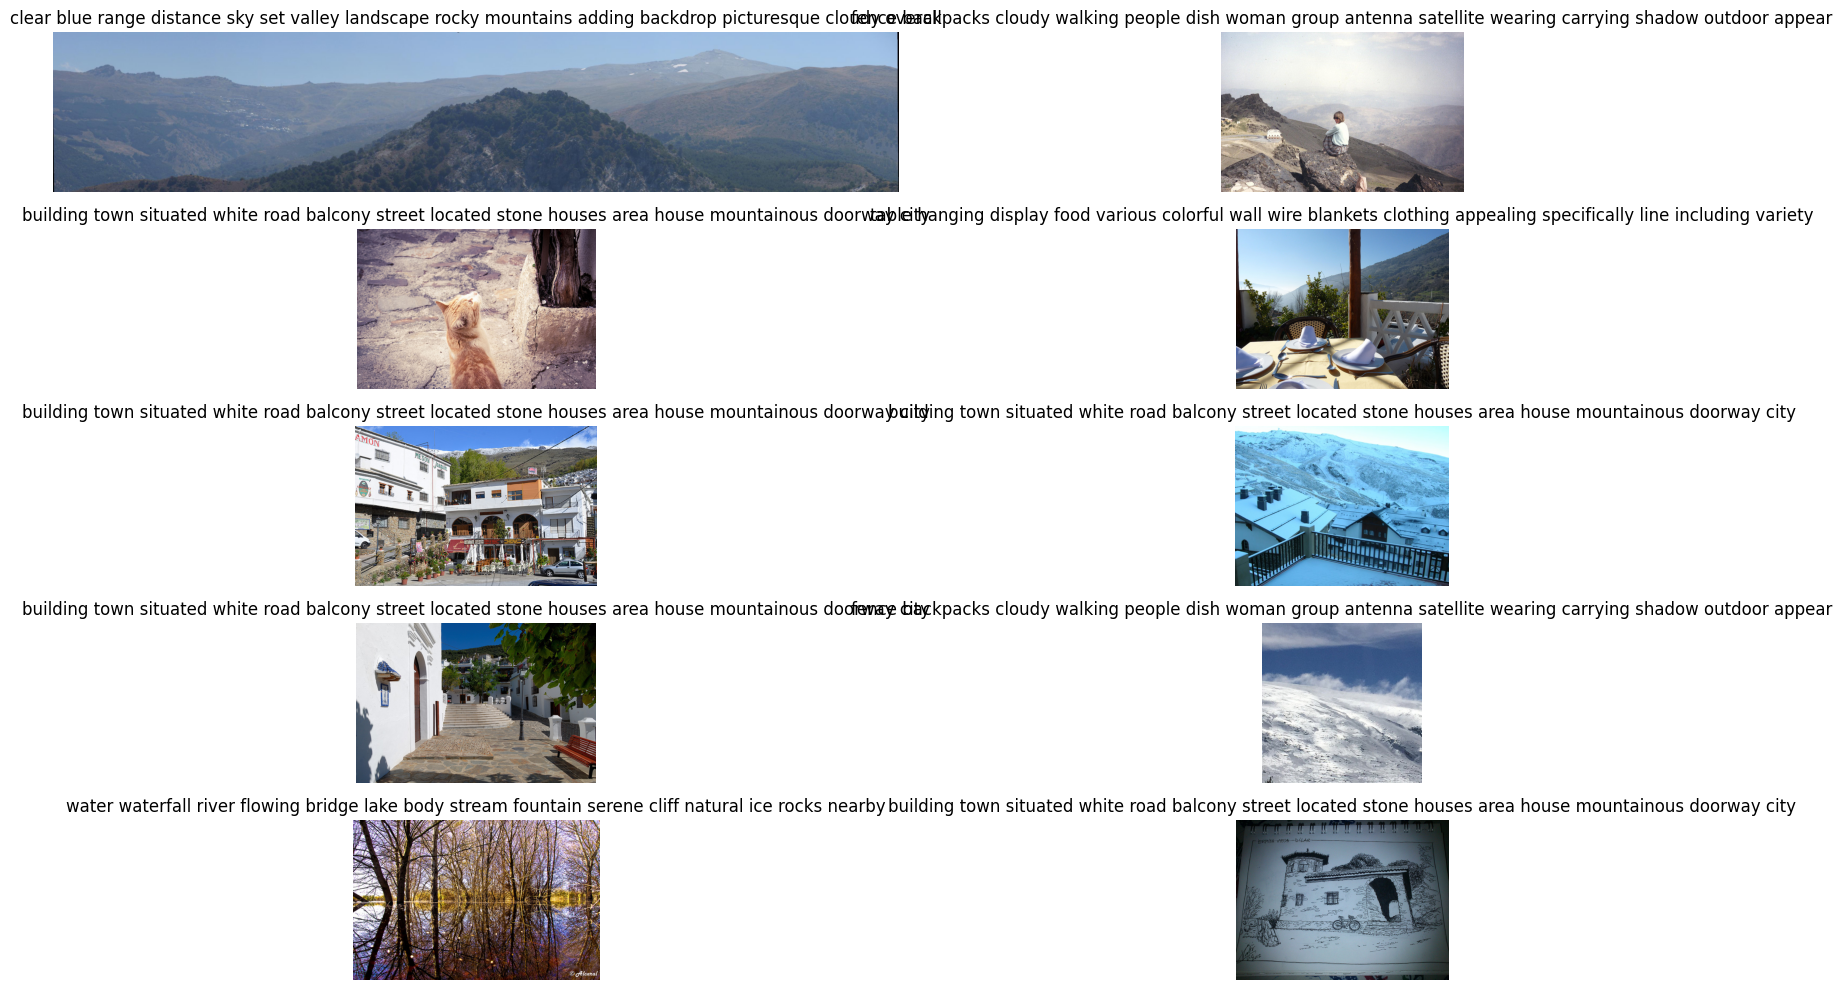

In [ ]:
def plot_random_images(image_paths, labels, num_images=10):
    # Ensure we don't request more images than we have
    num_images = min(num_images, len(image_paths))

    # Select random indices
    random_indices = random.sample(range(len(image_paths)), num_images)

    # Plot the selected images
    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(random_indices):
        image_path = image_paths[idx]
        label = labels[idx]

        # Open the image
        image = Image.open(image_path)

        # Add subplot
        plt.subplot(5, 2, i + 1)
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

image_paths = [f"{image_dir}/{key}" for key in captions.keys()]
plot_random_images(image_paths, result, num_images=10)
